In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
from hydra import compose, initialize
from omegaconf import OmegaConf
from netCDF4 import Dataset
from pathlib import Path
from pyresample import kd_tree
from pyresample import SwathDefinition
from pyresample.area_config import create_area_def
from pyresample.bilinear import NumpyBilinearResampler
from pyresample.geometry import AreaDefinition
from pyresample.plot import show_quicklook
from pyresample.utils import check_and_wrap
from cartopy.io import DownloadWarning

In [2]:
%matplotlib ipympl

# Exploring TC-PRIMED
[TC-PRIMED](https://rammb-data.cira.colostate.edu/tcprimed/) is a recent dataset put together by the NOAA, the Colorado State University Department of Atmospheric Science, and other insitutions. It includes data centered on Tropical Cyclones, with the most notable features being:
* Satellite Microwave images
* Infrared images from the [RAMMB/CIRA archive](https://satlib.cira.colostate.edu/media-archive/) and [HURSAT-B1](https://www.ncei.noaa.gov/products/hurricane-satellite-data) dataset
* ERA5 environment fields
* Best-track data giving TC characteristics.
* GPROF-estimated precipitations
* Satellite radar precipitations fields.

In this notebook, we'll explore the subset of TC-PRIMED corresponding to the year 2017, which already includes 51GB of data. We'll focus only the Atlantic (AL) basin.  
Note: the awesome authors of TC-PRIMED included a series of [tutorial notebooks](https://nbviewer.org/github/CSU-CIRA/tcprimed_learning_journey/tree/main/) on using TC-PRIMED. Moreover, the documentation is available at [this link](https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/TCPRIMED_v01r00_documentation.pdf).

# Imports and environment

In [3]:
%cd ..

/home/cdauvill/inria/multi_sources


In [4]:
# Import warnings and suppress relevant categories.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=DownloadWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
# context initialization
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="preproc", overrides=["paths=local"])

The dataset tree has the format ```root_dir/BASIN/XX/files.nc``` where ```XX``` is the number (starting at 01) of the storm during the season.

In [6]:
_TC_PRIMED_PATH_ = Path(cfg['paths']['raw_datasets']) / 'tc_primed/2014/AL/01'

# Single storm overpass file
We'll now load an entry from a single storm of the 2014 season.

In [7]:
storm_files = [_TC_PRIMED_PATH_ / file for file in os.listdir(_TC_PRIMED_PATH_) if "era5" not in str(file)]
storm_files = [file for file in storm_files if "AMSR2" in str(file)]
dataset = Dataset(storm_files[0])
print("Found keys ", dataset.groups.keys())

Found keys  dict_keys(['overpass_metadata', 'overpass_storm_metadata', 'passive_microwave', 'GPROF', 'infrared'])


## Microwave images

Let's look at the ```passive_microwave``` group:

In [8]:
dataset['passive_microwave']

<class 'netCDF4.Group'>
group /passive_microwave:
    title: NASA inter-calibrated passive microwave group for TC PRIMED
    summary: Tropical Cyclone Precipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED) NASA inter-calibrated passive microwave brightness temperature group
    comment: NASA inter-calibrated satellite passive microwave brightness temperature fields version V07A from the Precipitation Processing System (PPS), National Aeronautics and Space Administration (NASA). doi:10.5067/GPM/AMSR2/GCOMW1/1C/07
    Conventions: CF-1.11, ACDD-1.3
    id: TCPRIMED_v01r01-final_AL012014_AMSR2_GCOMW1_011304_20140702184545.nc
    source: 1C.GCOMW1.AMSR2.XCAL2016-V.20140702-S181419-E195311.011304.V07A.HDF5
    references: Berg, W., and Coauthors, 2016: Intercalibration of the GPM microwave radiometer constellation. J. Atmos. Oceanic Technol., 33, 2639-2654, doi:10.1175/JTECH-D-16-0100.1.
    naming_authority: edu.colostate.cira
    license: No constraints on data access o

The group includes four sub-groups: ```S1``` to ```S4```. This is because the ```SSMIS``` sensor includes four swaths. Each swatch has its own set of available frequencies and polarizations.

In [9]:
pmw = dataset['passive_microwave']
pmw['S1']

<class 'netCDF4.Group'>
group /passive_microwave/S1:
    title: NASA inter-calibrated passive microwave swath S1 group for TC PRIMED
    summary: Tropical Cyclone Precipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED) NASA inter-calibrated passive microwave swath S1 group
    comment: NASA inter-calibrated satellite passive microwave brightness temperature fields version V07A from the Precipitation Processing System (PPS), National Aeronautics and Space Administration (NASA). doi:10.5067/GPM/AMSR2/GCOMW1/1C/07
    Conventions: CF-1.11, ACDD-1.3
    id: TCPRIMED_v01r01-final_AL012014_AMSR2_GCOMW1_011304_20140702184545.nc
    source: 1C.GCOMW1.AMSR2.XCAL2016-V.20140702-S181419-E195311.011304.V07A.HDF5
    references: Berg, W., and Coauthors, 2016: Intercalibration of the GPM microwave radiometer constellation. J. Atmos. Oceanic Technol., 33, 2639-2654, doi:10.1175/JTECH-D-16-0100.1.
    naming_authority: edu.colostate.cira
    license: No constraints on data access or 

In [10]:
dataset['passive_microwave']['time'][0].data.item()

1404326745

In [11]:
d = xr.open_mfdataset(storm_files[:2], group="overpass_metadata")

In [12]:
d['time']

<xarray.DataArray 'time' (time: 2)> Size: 16B
array(['2014-07-01T07:04:09.000000000', '2014-07-02T18:45:45.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16B 2014-07-01T07:04:09 2014-07-02T18:45:45
Attributes:
    long_name:              Time of the passive microwave observation of the ...
    standard_name:          time
    axis:                   T
    coverage_content_type:  coordinate

The brightness temperatures are contained in the variables ```TB_XX.XXXP``` where ```XX.XXX``` is a frequency and ```P``` can be H, V, QH and QV and is the polarization.  
Let's plot every TB variable from the 37GHz swath:

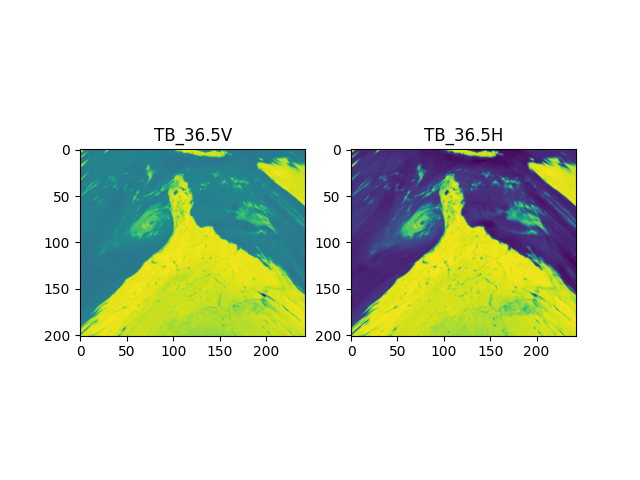

In [13]:
tb_vars = [var for var in list(pmw['S4'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S4'][var])
    ax.set_title(var)

Let's also look at the 89GHz swaths:

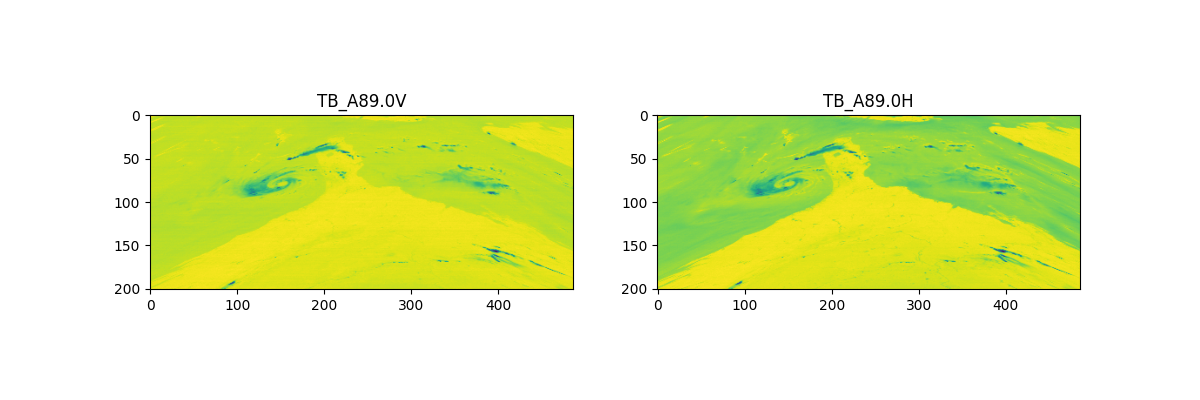

In [14]:
tb_vars = [var for var in list(pmw['S5'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars), figsize=(12, 4))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S5'][var])
    ax.set_title(var)

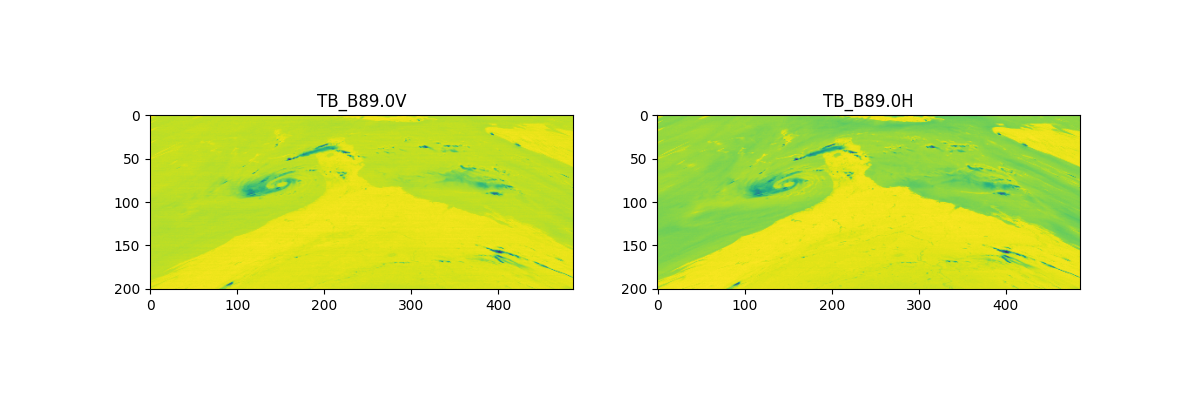

In [15]:
tb_vars = [var for var in list(pmw['S6'].variables.keys()) if var.startswith('TB')]

fig, axes = plt.subplots(nrows=1, ncols=len(tb_vars), figsize=(12, 4))
for ax, var in zip(axes, tb_vars):
    ax.imshow(pmw['S6'][var])
    ax.set_title(var)

The 89GHz swaths should cover the same area as the 37GHz, but with two times as many pixels.

89GHz swath shape: (201, 486), 37GHz swath shape: (201, 243)


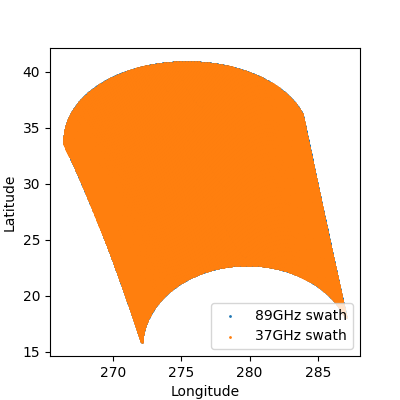

In [16]:
lat_89 = pmw['S5']['latitude'][:]
lon_89 = pmw['S5']['longitude'][:]
lat_37 = pmw['S4']['latitude'][:]
lon_37 = pmw['S4']['longitude'][:]
print(f"89GHz swath shape: {lat_89.shape}, 37GHz swath shape: {lat_37.shape}")
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(lon_89, lat_89, s=1, label='89GHz swath')
ax.scatter(lon_37, lat_37, s=1, label='37GHz swath')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

## Coordinates
One may notice that the ```latitude``` can be reversed (the top of the image is more to the south than the bottom), as the satellites have near-polar orbits and many choose to take pictures during their descending phase:

In [17]:
pmw['S1']['latitude'][:]

masked_array(
  data=[[18.1243, 18.2003, 18.2759, ..., 16.0085, 15.9275, 15.8464],
        [18.2163, 18.2923, 18.3679, ..., 16.0937, 16.0127, 15.9315],
        [18.3066, 18.3826, 18.4582, ..., 16.1832, 16.1021, 16.021 ],
        ...,
        [36.0189, 36.0957, 36.1722, ..., 33.5455, 33.4641, 33.3828],
        [36.1094, 36.1862, 36.2627, ..., 33.6332, 33.5519, 33.4706],
        [36.1979, 36.2747, 36.3512, ..., 33.7247, 33.6434, 33.5621]],
  mask=False,
  fill_value=np.float64(1e+20),
  dtype=float32)

In [18]:
pmw['S1']['longitude'][:]

masked_array(
  data=[[287.0105, 286.979 , 286.9466, ..., 272.1041, 272.0981, 272.093 ],
        [286.9935, 286.962 , 286.9295, ..., 272.0804, 272.0744, 272.0694],
        [286.9766, 286.945 , 286.9126, ..., 272.0563, 272.0504, 272.0454],
        ...,
        [283.8492, 283.8145, 283.7787, ..., 266.507 , 266.5073, 266.5086],
        [283.8342, 283.7994, 283.7636, ..., 266.4731, 266.4734, 266.4748],
        [283.8189, 283.7842, 283.7483, ..., 266.4385, 266.4388, 266.4402]],
  mask=False,
  fill_value=np.float64(1e+20),
  dtype=float32)

We might want to transpose the latitude and longitude coordinates in this case:

In [19]:
s4 = xr.open_dataset(xr.backends.NetCDF4DataStore(pmw['S4']))
s4 = s4.isel(scan=slice(None, None, -1)).isel(pixel=slice(None, None, -1))
s4.latitude

<xarray.DataArray 'latitude' (scan: 201, pixel: 243)> Size: 195kB
[48843 values with dtype=float32]
Coordinates:
    latitude   (scan, pixel) float32 195kB ...
    longitude  (scan, pixel) float32 195kB ...
Dimensions without coordinates: scan, pixel
Attributes:
    long_name:              The Earth latitude of the center of the IFOV at t...
    standard_name:          latitude
    units:                  degrees_north
    scan_type:              conical
    valid_range:            [-90.  90.]
    coverage_content_type:  coordinate

## Resampling to a regular grid
The images we just observed are NOT on a regular grid (such as a Mercator projection). Instead they're swaths, i.e. a band observed by a satellite. This means the spatial resolution varies between pixels that are at the center (nadir angle) and pixels that are on the edges of the swath. Furthermore, the coordinates are not oriented as we would usually have (north to south, west to east).  

Following [TC-PRIMED's tutorial notebook](https://colab.research.google.com/github/CSU-CIRA/tcprimed_learning_journey/blob/main/TCPRIMED_Chap4_RegriddingSwathData.ipynb#scrollTo=i_BQfL7GWMOQ), we'll use ```pyresample``` to do the gridding.

In [20]:
# Reformats the coordinates to make sure they follow the right conventions (e.g. longitude
# between -180 and 180).
lon, lat = check_and_wrap(s4.longitude.values, s4.latitude.values)

In [21]:
tb_vars = [var for var in list(pmw['S4'].variables.keys()) if var.startswith('TB')]
swath_data = s4[tb_vars[0]].values

In [22]:
swath = SwathDefinition(lon, lat)

In [23]:
# Create a dictionary specifying the projection
RADIUS_EARTH = 6371228.
proj_dict_merc = {
    'proj': 'merc',
    'lon_0': 0,
    'R': int(RADIUS_EARTH),
    'units': 'm'}

In [24]:
# Define the parameters necessary for the Mercator projection
NX = 1090  # number of pixels in x-direction (longitude)
NY = 1090  # number of pixels in y-direction (latitude)
DX = 0.03593244699965226  # longitude spatial resolution (degrees)
DY = 0.03593244699963805  # latitude spatial resolution (degrees)

In [25]:
# Define the mercator projection
AREA_ID = 'Mercator'
merc_area = create_area_def(
    AREA_ID, proj_dict_merc,
    center=(lon.mean(), lat.mean()),
    shape=(NX, NY),
    resolution=(DX, DY),
    units='degrees')

In [26]:
# Nearest neighbor grid interpolation
RADIUS_NN = 20000.  # radius of influence (m)
mercNN = kd_tree.resample_nearest(
    swath, swath_data, merc_area,
    radius_of_influence=RADIUS_NN)
print("Mercator Data Shape: {}".format(mercNN.shape))
print("     Min= {:.2f}, Max= {:.2f}".format(\
    mercNN.min(), mercNN.max()))

Mercator Data Shape: (1090, 1090)
     Min= 0.00, Max= 298.02


Text(0.5, 1.0, 'Nearest Neighbor Resampling of TB_36.5V to Mercator Grid')

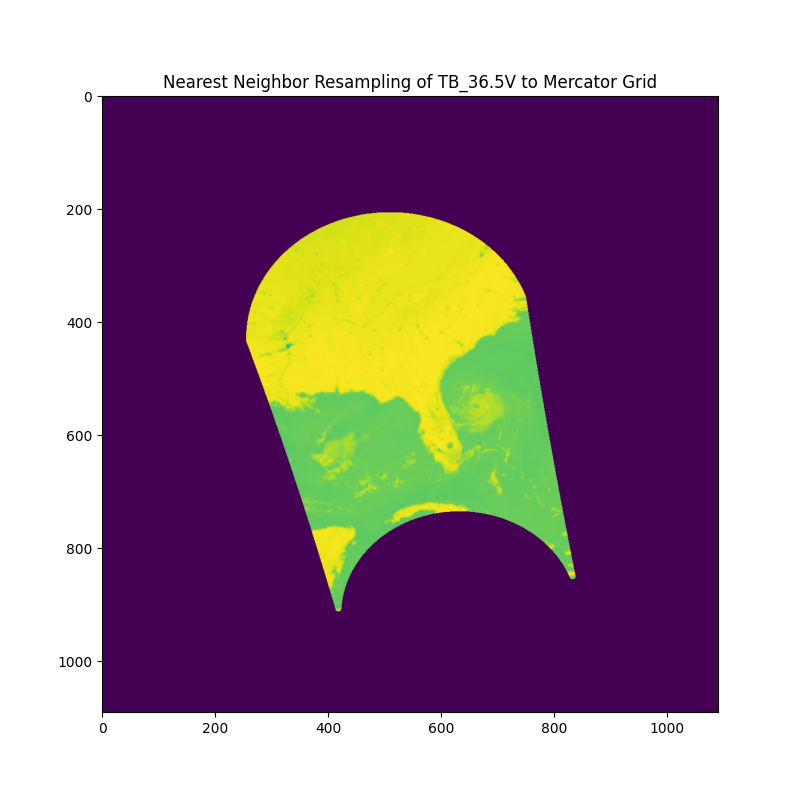

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(mercNN)
ax.set_title(f'Nearest Neighbor Resampling of {tb_vars[0]} to Mercator Grid')

## Infrared images

Let's now look at the ```infrared``` group. The infrared image is only available when the ```infrared_availability_flag``` attribute is not zero.

In [28]:
dataset['infrared']['infrared_availability_flag'][:]

masked_array(data=[1],
             mask=False,
       fill_value=np.int64(999999),
            dtype=int8)

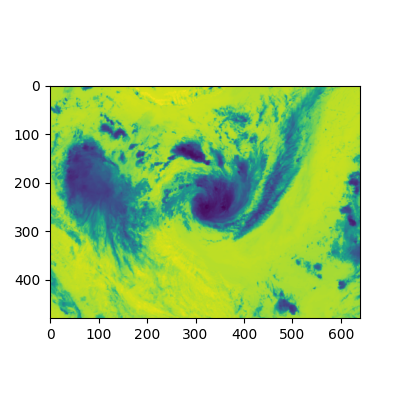

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(dataset['infrared']['IRWIN'])

## Radar - Radiometer
TC-PRIMED includes radar-radiometer products which combine radar and microwave observations to obtain the best precipitation estimates, which are also colocated with the microwave observations. However the swaths are much narrower, which means that the data is less likely to be over the cyclones.

### GPM (DPR and GMI)
We first need to isolate the files from the TRMM and GPM satellites, which are the ones that include radar-radiometer products:

In [30]:
gpm_files = [_TC_PRIMED_PATH_ / file for file in os.listdir(_TC_PRIMED_PATH_) if 'GPM' in file]
dataset = Dataset(gpm_files[5])
print("Found keys ", dataset.groups.keys())

Found keys  dict_keys(['overpass_metadata', 'overpass_storm_metadata', 'passive_microwave', 'GPROF', 'radar_radiometer', 'infrared'])


The file includes an availability flag:

In [31]:
dataset['radar_radiometer']['availability_flag'][0].item()

1

The GPM satellite's radar is the DPR, which uses two frequencies (13.8 and 35.5GHz), named the Ka and the Ku bands respectively.

#### Ku Band
TC-PRIMED includes many different products derived from the DPR and the GMI instruments (as well as their raw reflectivity). We'll focus here on the surface precipitation rate.

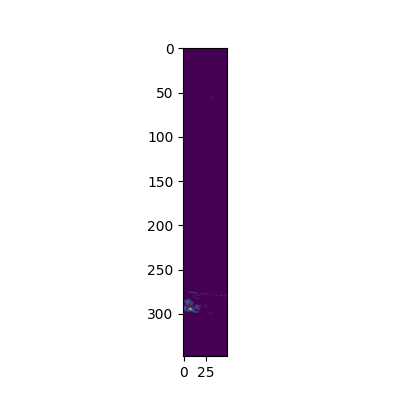

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(dataset['radar_radiometer']['KuGMI']['nearSurfPrecipTotRate'])

#### Ka Band

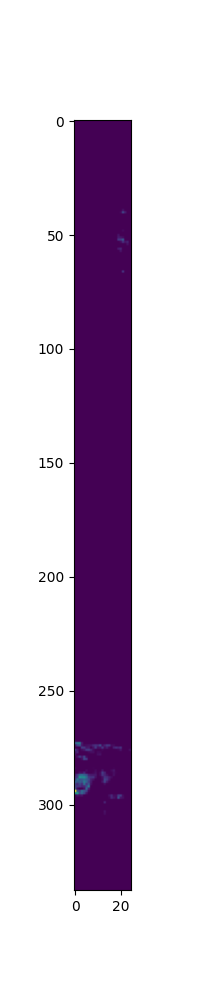

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(2, 10))
ax.imshow(dataset['radar_radiometer']['KuKaGMI']['nearSurfPrecipTotRate'])

# Single storm environmental file
We'll now load the environmental file for the same storm as previously. The environmental file includes notably:
* ERA5 fields centered on the storm, and 20° degrees wide in each cardinal direction around it.
* SHIPS diagnostics derived from IR imagery.
The ```rectilinear``` group contains the ERA5 fields.

In [34]:
# Retrieve the environment file, which is the only one that contain "env" in its filename.
env_file = [_TC_PRIMED_PATH_ / file for file in os.listdir(_TC_PRIMED_PATH_) if "env" in str(file)][0]
env_dataset = xr.open_mfdataset([env_file], group="rectilinear")
env_dataset

<xarray.Dataset> Size: 569MB
Dimensions:              (time: 45, ny: 121, nx: 121, level: 23)
Coordinates:
  * time                 (time) datetime64[ns] 360B 2014-06-28T18:00:00 ... 2...
  * level                (level) int16 46B 50 70 100 150 ... 925 950 975 1000
    latitude             (time, ny) float32 22kB dask.array<chunksize=(1, 121), meta=np.ndarray>
    longitude            (time, nx) float32 22kB dask.array<chunksize=(1, 121), meta=np.ndarray>
Dimensions without coordinates: ny, nx
Data variables: (12/18)
    precipitable_water   (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    rain_large_scale     (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    rain_convective      (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    sst                  (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    pressure_msl         (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    temperature_2m       (time, ny, nx) float32 3MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>
    ...                   ...
    u_wind               (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
    v_wind               (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
    geopotential_height  (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
    vorticity            (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
    divergence           (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
    vertical_velocity    (time, level, ny, nx) float32 61MB dask.array<chunksize=(1, 23, 121, 121), meta=np.ndarray>
Attributes: (12/51)
    title:                                                           Rectilin...
    summary:                                                         Tropical...
    source:                                                          Contains...
    references:                                                      Copernic...
    keywords:                                                        EARTH SC...
    keywords_vocabulary:                                             GCMD:GCM...
    ...                                                              ...
    geospatial_lat_max:                                              75.25132
    geospatial_lon_min:                                              265.74838
    geospatial_lon_max:                                              321.0006
    time_coverage_start:                                             2014-06-...
    time_coverage_end:                                               2014-07-...
    date_modified:                                                   2024-11-...

Text(0.5, 1.0, 'Example of Mean Sea Level Pressure patch')

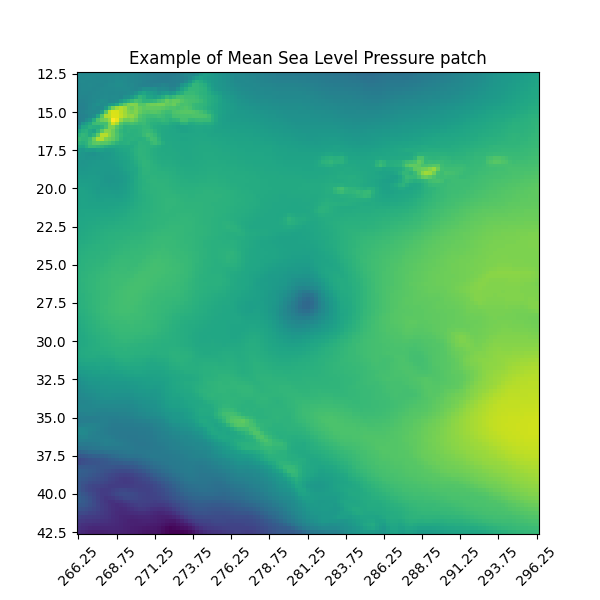

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
env_sample = env_dataset.isel(time=10)
ax.imshow(env_sample['pressure_msl'])
ax.set_xticks(np.arange(0, env_sample['longitude'].size, 10))
ax.set_xticklabels([f"{np.round(val, 2)}" for val in env_sample['longitude'].values[::10]], rotation=45)
ax.set_yticks(np.arange(0, env_sample['latitude'].size, 10))
ax.set_yticklabels([f"{np.round(val, 2)}" for val in env_sample['latitude'].values[::10]])
ax.set_title('Example of Mean Sea Level Pressure patch')

Let's have a look at the SHIPS diagnostics:

In [36]:
ships = xr.open_mfdataset([env_file], group="diagnostics")
ships

<xarray.Dataset> Size: 166kB
Dimensions:                               (time: 45, region: 1, regions: 4,
                                           layer: 2, bins: 5, level: 23)
Coordinates:
  * time                                  (time) datetime64[ns] 360B 2014-06-...
  * level                                 (level) int16 46B 50 70 ... 975 1000
  * bins                                  (bins) int16 10B 0 200 400 600 800
Dimensions without coordinates: region, regions, layer
Data variables: (12/50)
    number_radii                          int16 2B ...
    number_azimuths                       int16 2B ...
    delta_radius                          int16 2B ...
    delta_azimuth                         int16 2B ...
    center_latitude                       (time) float32 180B dask.array<chunksize=(45,), meta=np.ndarray>
    center_longitude                      (time) float32 180B dask.array<chunksize=(45,), meta=np.ndarray>
    ...                                    ...
    t_wind_500km                          (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
    t_wind                                (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
    geopotential_height                   (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
    vorticity                             (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
    divergence                            (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
    vertical_velocity                     (time, level, region) float32 4kB dask.array<chunksize=(1, 23, 1), meta=np.ndarray>
Attributes: (12/52)
    title:                                                           Diagnost...
    summary:                                                         Tropical...
    source:                                                          Contains...
    references:                                                      Slocum, ...
    keywords:                                                        EARTH SC...
    keywords_vocabulary:                                             GCMD:Glo...
    ...                                                              ...
    geospatial_lat_max:                                              60.299397
    geospatial_lon_min:                                              280.73325
    geospatial_lon_max:                                              305.90033
    time_coverage_start:                                             2014-06-...
    time_coverage_end:                                               2014-07-...
    date_modified:                                                   2024-11-...